In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import exists

### Data Loading

In [4]:
import os
path_raw_files = '../data'
files = [path_raw_files + '/' + files for files in os.listdir(path_raw_files)]

In [2]:
# Example of how to load times series csv file
# Each file contains data from approximately 50 devices
df = pd.read_csv('../data/devices2.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

# Data cleaning and resampling

<AxesSubplot:xlabel='diff_soc'>

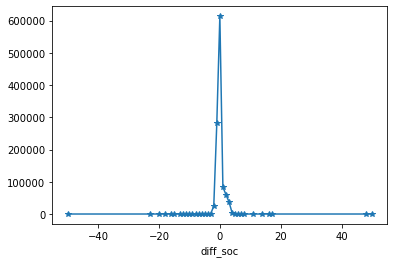

In [3]:
diff = df.reset_index()[['battery_id','state_of_charge_percent','timestamp']].dropna().sort_values(['battery_id','timestamp'])
diff = diff.reset_index(drop = True).reset_index().set_index(['index','battery_id'])
diff[['diff_soc','delta_time']] = diff.groupby('battery_id').diff()
diff['delta_seconds'] = diff['delta_time'].dt.total_seconds()
diff = diff.dropna()
diff.groupby('diff_soc').count()['timestamp'].plot(marker = '*')

<AxesSubplot:xlabel='battery_id', ylabel='diff_soc'>

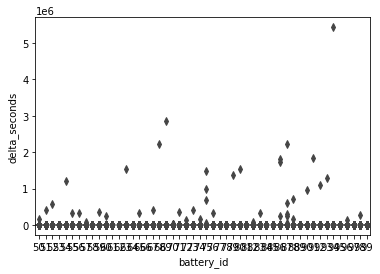

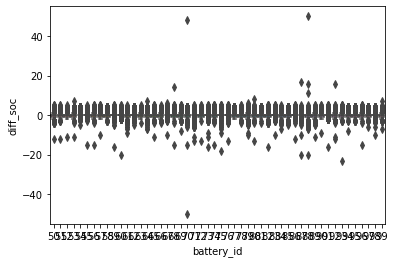

In [9]:
sns.boxplot(data = diff['delta_seconds'].reset_index(), x = 'battery_id', y = 'delta_seconds')
plt.figure()
sns.boxplot(data = diff['diff_soc'].reset_index(), x = 'battery_id', y = 'diff_soc')

From this, I think we can easily resample to a fixed frequency, let's say 10minutes, and we won't loose that much information

Let's check if we get a smooth curve this way

C:\Users\PC_victor\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


<AxesSubplot:xlabel='timestamp'>

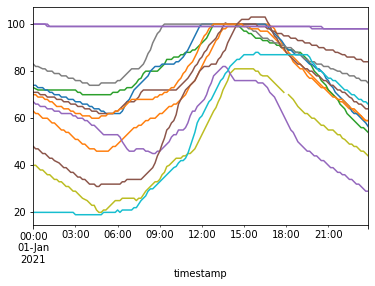

In [10]:
test = df.groupby('battery_id').resample('10min').mean()
test['state_of_charge_percent'].unstack('battery_id')['2021-01-01'].plot(legend = False)

Yes smooth curve, no 'gaps', I think it's validated

In [13]:
test = test.drop('battery_id', axis = 1)

<AxesSubplot:title={'center':'Boxplot of (delta_soc between two resampled observations 10min)'}, xlabel='battery_id'>

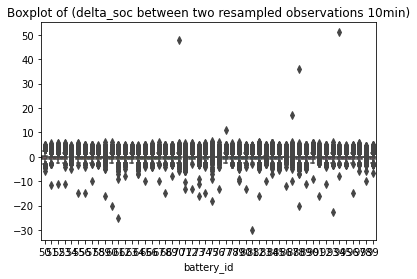

In [14]:
plt.title('Boxplot of (delta_soc between two resampled observations 10min)')
sns.boxplot(data = test.reset_index().set_index(['battery_id','timestamp'])['state_of_charge_percent'].diff().dropna().unstack(level = 0))

# missing values

In [15]:
df = df.dropna()

# clean values

we were worry about soc values > 100.
let's check this

In [16]:
df.describe()

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,usb_current,voltage,battery_id
count,1.108113e+06,1.108113e+06,1.108113e+06,1.108113e+06,1.108113e+06,1.108113e+06,1.108113e+06,1.108113e+06,1.108113e+06,1.108113e+06
mean,6.662620e+00,-7.719299e-03,2.609912e-01,2.532719e-01,3.848434e+00,7.494178e+01,2.696341e+01,7.725178e-02,7.050339e+00,7.418748e+01
std,1.318433e-01,6.019368e-01,5.202898e-01,2.564362e-01,3.820514e+00,2.235089e+01,2.693089e+00,1.547101e-01,8.917691e-01,1.417621e+01
min,5.605000e+00,-2.994000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.520027e+01,0.000000e+00,5.790000e+00,5.000000e+01
25%,6.570000e+00,-2.000000e-03,6.000000e-03,1.400000e-02,1.500000e-02,5.900000e+01,2.522774e+01,4.000000e-03,6.555000e+00,6.200000e+01
50%,6.650000e+00,1.200000e-02,6.000000e-03,2.040000e-01,5.075000e+00,7.700000e+01,2.710231e+01,4.000000e-03,6.640000e+00,7.400000e+01
75%,6.720000e+00,3.720000e-01,2.180000e-01,3.940000e-01,7.015000e+00,9.800000e+01,2.876173e+01,5.800000e-02,6.930000e+00,8.700000e+01
max,8.215000e+00,2.508000e+00,3.194000e+00,2.512000e+00,1.012000e+01,1.230000e+02,4.716182e+01,1.718000e+00,1.010000e+01,9.900000e+01


In [17]:
df.groupby('battery_id')['state_of_charge_percent'].agg(['min','mean','std','max',lambda x: np.quantile(x,q = 0.99)])
# it means only less than a percent of the data is > 100% SOC

# where could it come from? let's check this too


,min,mean,std,max,<lambda_0>
battery_id,,,,,
50,20.0,62.078716,25.687206,112.0,100.0
51,19.0,67.542904,26.186152,112.0,100.0
52,33.0,77.925901,18.640105,111.0,100.0
53,20.0,74.112661,20.508998,111.0,100.0
54,47.0,86.165353,12.634729,105.0,100.0
55,19.0,76.514922,20.647096,115.0,100.0
56,19.0,76.695351,21.268903,115.0,100.0
57,20.0,78.409124,18.397737,110.0,100.0
58,19.0,71.221224,20.609764,101.0,100.0


In [18]:
df[df['state_of_charge_percent'] > 102.].describe()

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,usb_current,voltage,battery_id
count,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000
mean,6.858405,-0.508590,0.571371,0.062781,7.594231,111.159071,27.960292,0.042517,7.020523,69.072386
std,0.205666,0.713393,0.723370,0.150246,1.119284,6.909179,3.410667,0.132849,0.486855,11.931870
min,6.570000,-2.572000,0.004000,0.002000,0.015000,103.000000,20.640879,0.000000,6.555000,50.000000
25%,6.670000,-0.923000,0.006000,0.006000,7.165000,104.000000,25.278096,0.004000,6.675000,60.000000
50%,6.765000,-0.044000,0.100000,0.006000,8.075000,109.000000,27.214466,0.004000,6.770000,61.000000
75%,7.070000,0.000000,1.069000,0.014000,8.145000,118.000000,29.686427,0.004000,7.215000,79.000000
max,8.215000,0.578000,2.578000,0.960000,9.210000,123.000000,39.443809,0.954000,9.270000,99.000000


not sure there is useful information in there.
I'll clip them, but keep that in made for later

In [19]:
df['state_of_charge_percent'] = df['state_of_charge_percent'].clip(0.,100.)

# Feature work

<AxesSubplot:>

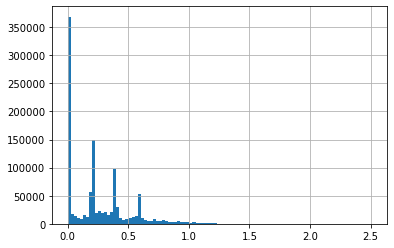

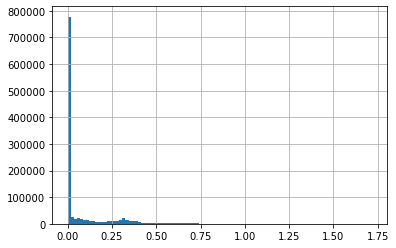

In [39]:
#power and current
df['power_out'] = df['current_out']*df['battery_voltage']
df['usb_power'] = df['usb_current']*df['battery_voltage']
df['power_in'] = df['current_in']*df['battery_voltage']
df['net_power_battery'] = -df['current']*df['battery_voltage']
#current_out
df['current_out'].hist(bins = 100)
plt.figure()
df['usb_current'].hist(bins = 100)

In [21]:
((df['current_out'] - df['current_in']).round(3) == df['current'].round(3)).mean()

1.0

In [22]:
df['other_out_current'] = df['current_out'] - df['usb_current']

In [23]:
corr_currents = df[['current_out','usb_current','battery_id']].groupby('battery_id').corr().unstack(level = 1)['current_out','usb_current']

<AxesSubplot:xlabel='battery_id'>

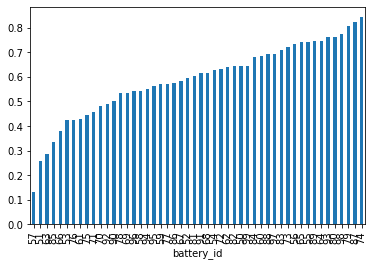

In [24]:
corr_currents.sort_values().plot.bar()

In [25]:
corr_currents = corr_currents.to_frame()
corr_currents[['mean_current_out','mean_usb_current']] = df[['current_out','usb_current','battery_id']].groupby('battery_id').mean()

In [26]:
corr_currents[['mean_power_out','mean_usb_power']] = df[['power_out','usb_power','battery_id']].groupby('battery_id').mean()

In [27]:
corr_currents['share_current'] = corr_currents['mean_usb_current'] / corr_currents['mean_current_out']
corr_currents['share_power'] = corr_currents['mean_usb_power'] / corr_currents['mean_power_out']

In [31]:
corr_currents

,current_out,mean_current_out,mean_usb_current,mean_power_out,mean_usb_power,share_current,share_power
,usb_current,,,,,,
battery_id,,,,,,,
50,0.644624,0.348356,0.099101,2.274072,0.654351,0.284483,0.287744
51,0.256570,0.275988,0.024866,1.811591,0.165508,0.090099,0.091361
52,0.597119,0.262630,0.090918,1.736786,0.604335,0.346182,0.347962
53,0.425516,0.269509,0.048676,1.779673,0.325062,0.180610,0.182653
54,0.628601,0.139808,0.053401,0.926630,0.356163,0.381957,0.384364
55,0.744451,0.229000,0.099354,1.522610,0.663629,0.433860,0.435850
56,0.733316,0.256121,0.076008,1.696568,0.502770,0.296768,0.296345
57,0.129952,0.199895,0.014317,1.318785,0.096154,0.071622,0.072911


<AxesSubplot:xlabel='battery_id'>

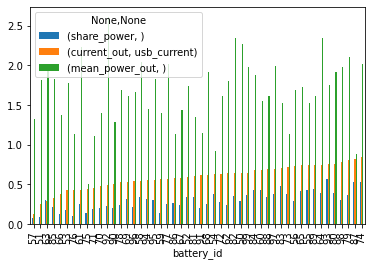

In [32]:
corr_currents.sort_values(('current_out','usb_current'))[['share_power','current_out','mean_power_out']].plot.bar()

In [41]:
df['bool_current_out'] = df['current_out'] > 2e-2
df['bool_current_in'] = df['current_in'] > 2e-2

In [42]:
df_usage = df[df['bool_current_out']]
df_charging = df[df['bool_current_in']]

<AxesSubplot:>

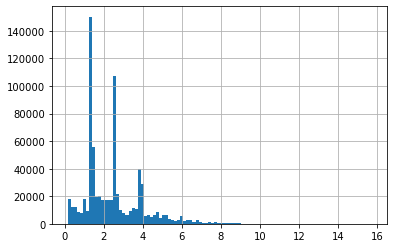

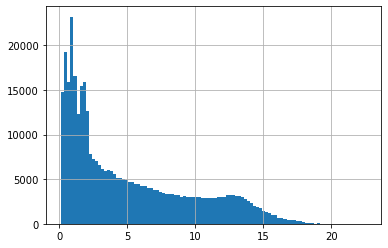

In [43]:
df_usage['power_out'].hist(bins = 100)
plt.figure()
df_charging['power_in'].hist(bins = 100)

# finally resampling

In [44]:
df = df.groupby('battery_id').resample('10min').mean()
df = df.drop('battery_id', axis = 1)

df = df.reset_index().set_index('timestamp')

In [45]:
df['hour'] = df.index.hour
df['minutes'] = df.index.minute
df['day_n'] = df.index.weekday

In [46]:
df['hour:min'] = df['hour'].astype(str) + ':' + df['minutes'].astype(str)

In [52]:
import os
if os.path.isdir('../data/cleaned_data'):
    print("Exists")
else:
    print("Doesn't exists")
    os.mkdir('../data/cleaned_data')

Doesn't exists


In [ ]:
file_cleaned_name = "data2"
df.to_csv(f'../data/cleaned_data/{file_cleaned_name}.csv')